In [12]:
import pandas as pd
import numpy as np
import re
import nltk 
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import os

nltk.download('stopwords')

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chiawei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data: Airline Reviews from Kaggle

In [31]:
# data downloaded from url
data_source_url = "https://raw.githubusercontent.com/kolaveridi/kaggle-Twitter-US-Airline-Sentiment-/master/Tweets.csv"
airline_tweets = pd.read_csv(data_source_url)

## Input: Text Reviews

In [14]:
airline_tweets.text.head(10)

0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus you've added commercials t...
2    @VirginAmerica I didn't today... Must mean I n...
3    @VirginAmerica it's really aggressive to blast...
4    @VirginAmerica and it's a really big bad thing...
5    @VirginAmerica seriously would pay $30 a fligh...
6    @VirginAmerica yes, nearly every time I fly VX...
7    @VirginAmerica Really missed a prime opportuni...
8      @virginamerica Well, I didn't…but NOW I DO! :-D
9    @VirginAmerica it was amazing, and arrived an ...
Name: text, dtype: object

## Output: Sentiment

In [15]:
airline_tweets.airline_sentiment.unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [16]:
plot_size = plt.rcParams["figure.figsize"]
plot_size[0] = 8
plot_size[1] = 6
plt.rcParams["figure.figsize"] = plot_size 

<AxesSubplot:xlabel='airline'>

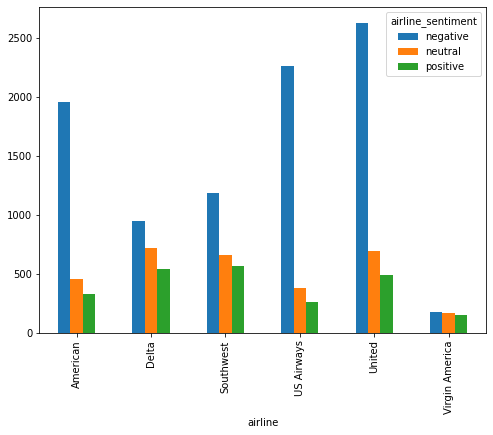

In [17]:
airline_sentiment = airline_tweets.groupby(['airline', 'airline_sentiment']).airline_sentiment.count().unstack()
airline_sentiment.plot(kind='bar')

<AxesSubplot:xlabel='airline_sentiment', ylabel='airline_sentiment_confidence'>

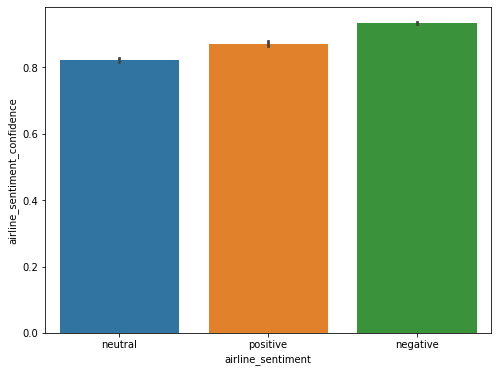

In [18]:
sns.barplot(x='airline_sentiment', y='airline_sentiment_confidence' , data=airline_tweets)

In [19]:
features = airline_tweets.iloc[:, 10].values
labels = airline_tweets.iloc[:, 1].values

# Text preprocessing

In [20]:
def preprocess(feature):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(feature))

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature) 

    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    return processed_feature

In [21]:
import re

processed_features = []

for sentence in features:

    processed_features.append(preprocess(sentence))

# Tokenization

In [22]:
vectorizer = TfidfVectorizer(max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))

processed_features = vectorizer.fit_transform(processed_features).toarray()

### Split data into training and testing set

In [23]:
X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=0)

# Machine Learning: Random Forest Classifier

In [24]:
text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=0)

In [25]:
predictions = text_classifier.predict(X_test)

In [26]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[1723  108   39]
 [ 326  248   40]
 [ 132   58  254]]
              precision    recall  f1-score   support

    negative       0.79      0.92      0.85      1870
     neutral       0.60      0.40      0.48       614
    positive       0.76      0.57      0.65       444

    accuracy                           0.76      2928
   macro avg       0.72      0.63      0.66      2928
weighted avg       0.75      0.76      0.74      2928

0.7599043715846995


### Testing with single sample 

In [27]:
test_input = [preprocess("@VirginAmerica I didn't flytoday... Must mean I need to take another trip!")]

test_feature = vectorizer.transform(test_input).toarray()

test_prediction = text_classifier.predict(test_feature)

test_prediction

array(['neutral'], dtype=object)

# Reproducibility: Saving of Model and Tokenizer

In [28]:
savedpath = "../deploy/resources"

if not os.path.exists(savedpath):
    
    print(f"Creating model and vectorizer saved path at {savedpath}")
    os.makedirs(savedpath)

model_path = os.path.join(savedpath, "sklearn_model.pickle")
vectorizer_path = os.path.join(savedpath, "sklearn_vectorizer.pickle")

pickle.dump(text_classifier, open(model_path, "wb")) # wb for writing to a binary file
pickle.dump(vectorizer, open(vectorizer_path, "wb"))

Creating model and vectorizer saved path at ../deploy/resources


### Micellaneous: Testing if result same with loaded model

In [30]:
#load model 
file_to_load = open(model_path, 'rb')
loaded_classifier = pickle.load(file_to_load)

loaded_vectorizer = pickle.load(open(vectorizer_path, 'rb'))
test_loaded_feature = loaded_vectorizer.transform(test_input).toarray()

loaded_prediction = loaded_classifier.predict(test_loaded_feature)

loaded_prediction

array(['neutral'], dtype=object)